# TP 2 : Signature Plot, Epps Effect and Link between Spread and Volatility per trade

## I. Volatility Estimator and Signature Plot

### 1. Signature Plot

Let $P$ be the price process, $X=\log P$ be the log-price process and $\Delta$ the discretization step over a time period $[0,T]$. Set for every $j\in{1,\ldots,T/\Delta}$, $r_{\Delta}(j)=X_{\Delta j}-X_{\Delta(j-1)}$ the log-price increments. Thus, in the Itô semi-martingale framework, the integrated variance reads
$$\int_0^T\sigma^2_sds=\lim_{\Delta\to0}\sum_{j=1}^{T/\Delta}r_{\Delta}(j)^2.$$
Consequently, a "natural" estimator for the integrated variance is 
$$\hat{V}_R(\Delta)=\sum_{j=1}^{T/\Delta}r_{\Delta}(j)^2.$$
This estimator is consistent since 
$$\hat{V}_R(\Delta)\overset{\mathbb{P}}{\underset{\Delta\to0}{\longrightarrow}}\int_0^T\sigma^2_sds.$$

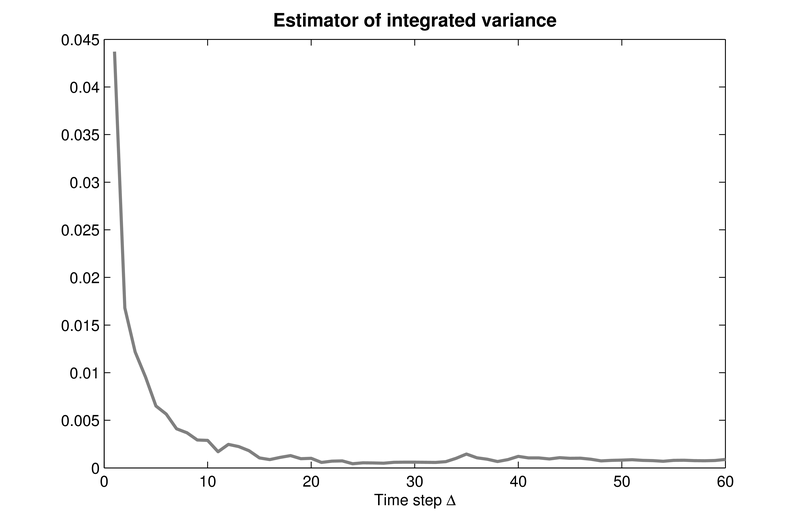

In [2]:
from IPython.display import Image
Image(filename='SignaturePlot.png', width=500)

_Estimator for the integrated variance computed for Rio Tinto between 03/01/2012 and 19/06/2012 according to the time discretization step._

They are many other ways to estimate the volatility: for example by using the minimum and the maximum of the price (see Garman & Klass), by considering multi-scale (see Ait-Sahalia or Ait-Sahalia & Jacod}) or by bid-ask modeling (see Robert & Rosenbaum).

**Observations and microstructure.** A model for log-price observation $X$ may be $X=M+\varepsilon$, where $M$ is a semi-martingale and $\varepsilon$ is the noise. Consequently
$$r_{\Delta}(j)=M_{\Delta j}-M_{\Delta(j-1)}+\varepsilon_{\Delta j}-\varepsilon_{\Delta(j-1)}=r^M_{\Delta}(j)+\eta_{\Delta}(j).$$
Thus the realized varince reads
$$\hat{V}_R(\Delta)=\sum_{j=1}^{T/\Delta}r_{\Delta}(j)^2=\sum_{j=1}^{T/\Delta}r^M_{\Delta}(j)^2+\sum_{j=1}^{T/\Delta}\eta_{\Delta}(j)^2+\sum_{j=1}^{T/\Delta}r^M_{\Delta}(j)\eta_{\Delta}(j).$$
This estimator diverges when $\Delta\to0$.

<font color='blue'>**To do.** Plot $\hat{V}_R(\Delta)$ with respect to $\Delta$ (in minutes and seconds) for all the assets. Do it for the mid-prices and the log-mid-prices. Comment the results.</font>

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [4]:
df1 = pd.read_hdf("data/TOTAL.h5")
df1["MidPrice"] = 0.5 * ( df1['AskPrice'] + df1['BidPrice'])
df1["DiffMidPrice"] = df1["MidPrice"].diff().fillna(0)
df1["LogMidPrice"] = np.log(df1["MidPrice"])
df1["DiffLogMidPrice"] = df1["LogMidPrice"].diff().fillna(0)
df1.head()

,TradedPrice,TradedQty,BidPrice,AskPrice,BidQty,AskQty,TradedSign,MidPrice,DiffMidPrice,LogMidPrice,DiffLogMidPrice
Time,,,,,,,,,,,
2011-01-03 09:00:01.988,40.19,70,40.01,40.19,660800,40700,1,40.1,0.0,3.691376,0.0
2011-01-03 09:00:01.988,40.19,15,40.01,40.19,660800,40700,1,40.1,0.0,3.691376,0.0
2011-01-03 09:00:01.988,40.19,67,40.01,40.19,660800,40700,1,40.1,0.0,3.691376,0.0
2011-01-03 09:00:01.988,40.19,20,40.01,40.19,660800,40700,1,40.1,0.0,3.691376,0.0
2011-01-03 09:00:01.988,40.19,250,40.01,40.19,660800,40700,1,40.1,0.0,3.691376,0.0


In [5]:
N = 100 # N=T/delta
deltas = np.linspace(10, 10000, N).astype(int)
var1 = []
var2 = []

for i in range(N):
    var1.append( (df1["MidPrice"].resample(str(deltas[i])+"s").last().diff().dropna()**2).sum() )
    var2.append( (df1["LogMidPrice"].resample(str(deltas[i])+"s").last().diff().dropna()**2).sum() )

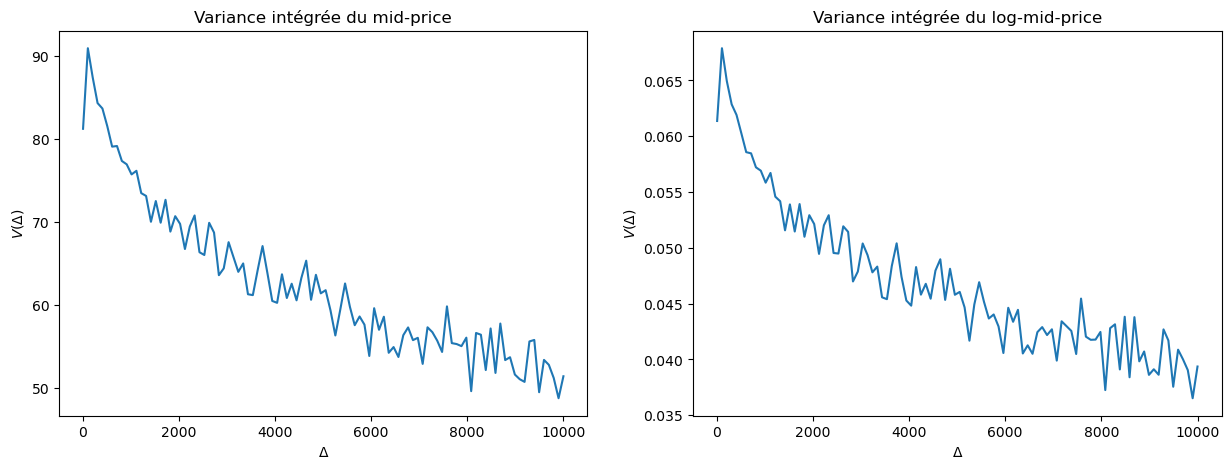

In [6]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].plot(deltas, var1)
ax[0].set_xlabel("$\Delta$")
ax[0].set_ylabel("$V(\Delta)$")
ax[0].set_title("Variance intégrée du mid-price")
ax[1].plot(deltas,var2)
ax[1].set_xlabel("$\Delta$")
ax[1].set_ylabel("$V(\Delta)$")
ax[1].set_title("Variance intégrée du log-mid-price")
plt.show()

We can see that the integrated variance of the mid price and the log mid price decreases as $\Delta$ gets bigger.

### 2. Intraday Volatility Estimator of Garman and Klass

They consider consider intraday volatility estimators that are based upon the historical opening, closing, high, and low prices and transaction volume. Since high and low prices require continuous monitoring to obtain, they correspondingly contain superior information content, exploited herein.

Their model assumes that a diffusion process governs security prices
$$P_t = \Phi(X_t)$$
where $P$ is the security price, $t$ is time, $\Phi$ is a monotonic, time-independent transformation, and $X_t$ is a diffusion process with the differential representation
$$dX_t = \sigma dW_t$$
where $W_t$ is the standard Brownian motion and $\sigma$ is an unknown constant to be estimated.

**"Best" Analytic Scale-invariant Estimators**

They consider estimators depending on
- the opening price,
- the closing price,
- the high price
- the low price.

For the authors, an estimator is "best" when it has minimum variance and is unbiased. They also impose the requirements that the estimators be analytic with price and time symmetries and scale-invariant. Under regularity condition (analytic in a neighborhood of the
origin), they obtain that the estimator must be quadratic in its arguments. Owing scale invariance and analyticity, they reduce the problem and find the "best" estimator of this form (unbiased with minimum variance). 

Finally, by eliminating the cross-product terms, the recommended and "more practical" estimator reads
$$\sigma_{GK}^2=\frac12\left(\mbox{High}-\mbox{Low}\right)^2-(2\ln2-1)\left(\mbox{Close}-\mbox{Open}\right)^2.$$

<font color='blue'>**To do.** 1. Compute the integrated variance with the Garman-Klass volatility estimator of both mid- and log-mid prices with respect to $\Delta$. Compare the results with the previous one.</font>

In [7]:
N = 100
deltas = np.linspace(10, 10000, N).astype(int)
varGK1 = []
varGK2 = []

for i in range(N):
    ohlc1 = df1["MidPrice"].resample(str(deltas[i])+"s").ohlc().dropna()
    ohlc2 = df1["LogMidPrice"].resample(str(deltas[i])+"s").ohlc().dropna()
    v1 = 0.5 * (ohlc1['high'] - ohlc1['low'])**2 - (2*np.log(2)-1) * (ohlc1['close'] - ohlc1['open'])**2
    v2 = 0.5 * (ohlc2['high'] - ohlc2['low'])**2 - (2*np.log(2)-1) * (ohlc2['close'] - ohlc2['open'])**2
    varGK1.append(v1.sum())
    varGK2.append(v2.sum())

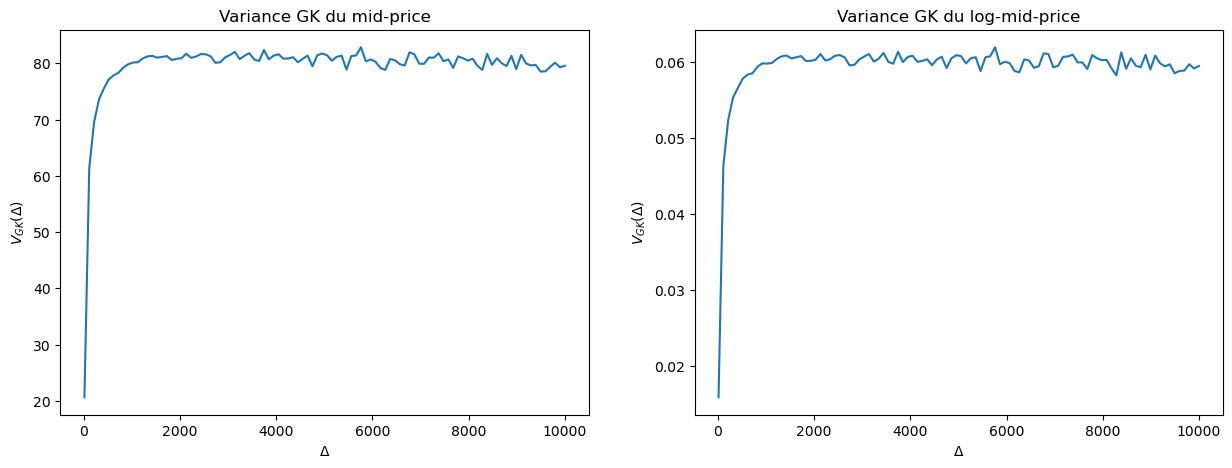

In [8]:
fig, axes = plt.subplots(1,2, figsize=(15,5))
axes[0].plot(deltas, varGK1)
axes[0].set_xlabel("$\Delta$")
axes[0].set_ylabel("$V_{GK}(\Delta)$")
axes[0].set_title("Variance GK du mid-price")
axes[1].plot(deltas,varGK2)
axes[1].set_xlabel("$\Delta$")
axes[1].set_ylabel("$V_{GK}(\Delta)$")
axes[1].set_title("Variance GK du log-mid-price")
plt.show()

We can see that as $\Delta$ gets bigger, we have convergence of the GK Variance estimator.

<font color='blue'> 2. Compute the daily volatility with $\sigma_{GK}$ and $\hat{\sigma}$ (the standard deviation of the mid-price and log-mid-price). Compare and comment the results.</font>

In [9]:
ohlc1 = df1["MidPrice"].resample("D").ohlc().dropna()
ohlc2 = df1["LogMidPrice"].resample("D").ohlc().dropna()
VolGK1 = np.sqrt( 0.5 * (ohlc1['high'] - ohlc1['low'])**2 - (2*np.log(2)-1) * (ohlc1['close'] - ohlc1['open'])**2 )
VolGK2 = np.sqrt( 0.5 * (ohlc2['high'] - ohlc2['low'])**2 - (2*np.log(2)-1) * (ohlc2['close'] - ohlc2['open'])**2 )
Vol1 = np.sqrt( (df1["DiffMidPrice"]**2 ).resample("D").sum().dropna() )
Vol2 = np.sqrt( (df1["DiffLogMidPrice"]**2 ).resample("D").sum().dropna() )

In [10]:
Vol1 = Vol1[Vol1>0]
Vol2 = Vol2[Vol2>0]

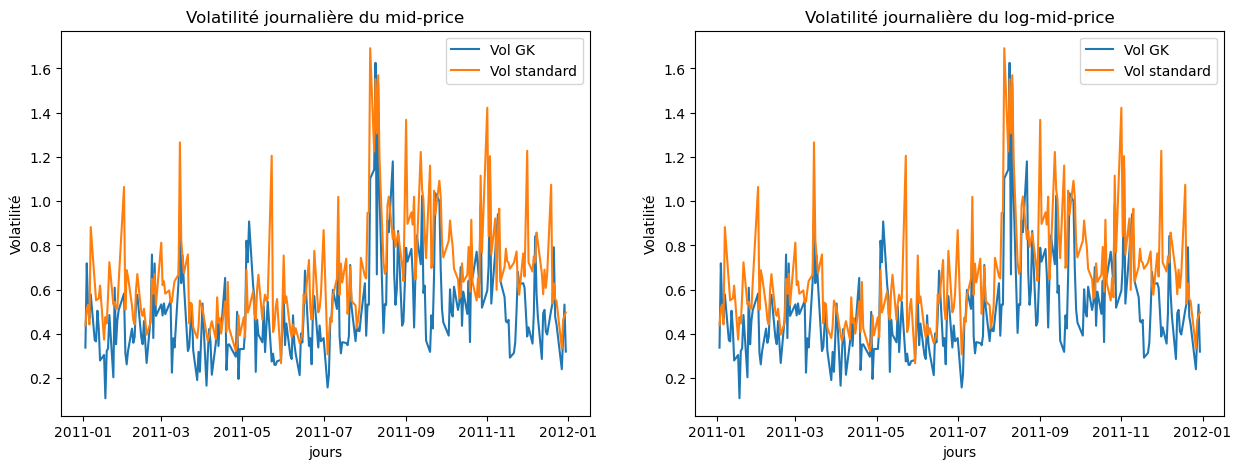

In [11]:
fig, axes = plt.subplots(1,2, figsize=(15,5))
axes[0].plot(VolGK1, label="Vol GK")
axes[0].plot(Vol1, label="Vol standard")
axes[0].set_xlabel("jours")
axes[0].set_ylabel("Volatilité")
axes[0].set_title("Volatilité journalière du mid-price")
axes[0].legend()
axes[1].plot(VolGK1, label="Vol GK")
axes[1].plot(Vol1, label="Vol standard")
axes[1].set_xlabel("jours")
axes[1].set_ylabel("Volatilité")
axes[1].set_title("Volatilité journalière du log-mid-price")
axes[1].legend()
plt.show()

We can see that for different estimators, we observe the same rough pattern for volatility.

## II. Covariance Estimator and Epps Effect

### 1. "Classical" Covariance Estimator

Let $X^1= \log P^1$ and $X^2 = \log P^2$ be two log-price processes. 
$$d X^1 = \mu_t^1dt+\sigma_{t-}^1dW^1_t,$$
$$d X^2 = \mu_t^2dt+\sigma_{t-}^2dW^2_t,$$
with $d\left\langle W^1,W^2\right\rangle_t=\rho_tdt$.

Set for every $j\in{1,\ldots,T/\Delta}$, $r^1_{\Delta}(j)=X^1_{\Delta j}-X^1_{\Delta(j-1)}$ and $r^2_{\Delta}(j)=X^2_{\Delta j}-X^2_{\Delta(j-1)}$ the log-price increments.

Then the integrated covariance between the two assets reads
$$\int_0^T\rho_s\sigma^1_s\sigma^2_sds=\lim_{\Delta\to0}\sum_{j=1}^{T/\Delta}r^1_{\Delta}(j)r^2_{\Delta}(j).$$
Thus, an estimator for the realized covariance may be written as 
$$\hat{C}_R(\Delta)=\sum_{j=1}^{T/\Delta}r^1_{\Delta}(j)r^2_{\Delta}(j).$$ 
This estimator is consistent since 
$$\hat{C}_R(\Delta)\overset{\mathbb{P}}{\underset{\Delta\to0}{\longrightarrow}}\int_0^T\rho_s\sigma^1_s\sigma^2_sds.$$ 

The problem is that we must have synchronous data, but the quotations and transactions are asynchronous.

### 2. Previous Tick Estimator

Assume now that we observe $P^1$ at times $(T^1_j)_{j\geq1}$ and $P^2$ at times $(T^2_j)_{j\geq1}$. Therefore we design 
$$\bar{P}^1_t=P_{T^1_j} \quad\mbox{for }t\in[T^1_j,T^1_{j+1})$$
and
$$\bar{P}^2_t=P_{T^2_j} \quad\mbox{for }t\in[T^2_j,T^1_{j+1}).$$
Then 
$$\bar{X}^1_t=\log \bar{P}^1_t \quad\mbox{and}\quad\bar{X}^2_t=\log \bar{P}^2_t/$$

For a given $\Delta$, the previous tick covariation estimator is
$$\bar{C}_R(\Delta)=\sum_{j=1}^{T/\Delta}\left(\bar{X}^1_{\Delta j}-\bar{X}^1_{\Delta (j-1)}\right)\left(\bar{X}^2_{\Delta j}-\bar{X}^2_{\Delta (j-1)}\right).$$

### 3. Epps Effect

Epps (1979): "Correlations among price changes [...] are found to decrease with the length of the interval for which the price changes are measured."
Many explanations were proposed
- systematic bias for this estimator,
- "lead-lag" effect for the assets in the same sector,
- asynchronicity of transactions,
- "tick" effect and other microstructure effects.

**Example.** Assume that $X^1$ and $X^2$ are two Brownian motions with correlation $\rho$ and the trade times are arrival times of two independent Poisson processes. Then, one can show that
$$\mathbb{E}[\bar{C}_R(\Delta)]\underset{\Delta\to0}{\longrightarrow}0.$$

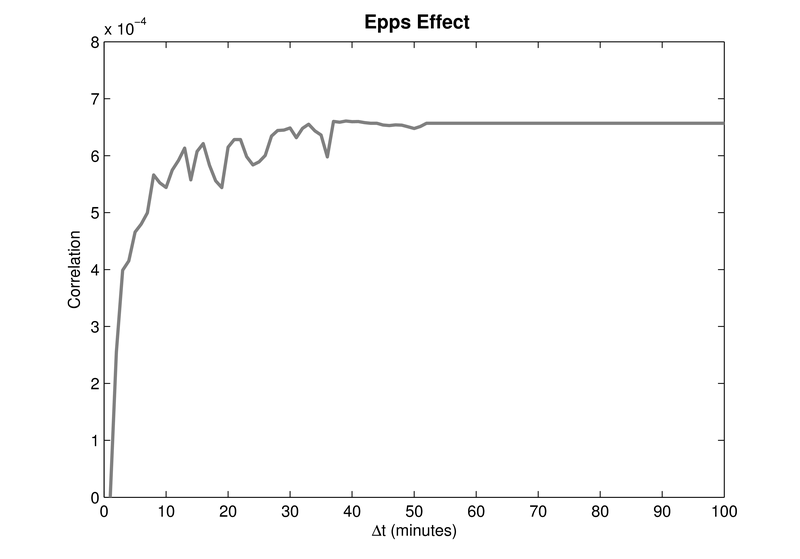

In [12]:
Image(filename='EppsEffect.png', width=500)

_Estimator for the correlation between Total and France Telecom on Euronext Paris on the period from 23/07/2012 to 27/07/2012 as a function of time discretization step._

<font color='blue'>**To do.** Plot the correlation with respect to $\Delta$ (in minutes or seconds) for couples of asset on the same exchange (using the mid-price and the log-mid-price). Comment the results.</font>

In [13]:
df2 = pd.read_hdf("data/BOUYGUES.h5")
df2["MidPrice"] = 0.5 * ( df2['AskPrice'] + df2['BidPrice'])
df2["DiffMidPrice"] = df2["MidPrice"].diff().fillna(0)
df2["LogMidPrice"] = np.log(df2["MidPrice"])
df2["DiffLogMidPrice"] = df2["LogMidPrice"].diff().fillna(0)
df2.head()

,TradedPrice,TradedQty,BidPrice,AskPrice,BidQty,AskQty,TradedSign,MidPrice,DiffMidPrice,LogMidPrice,DiffLogMidPrice
Time,,,,,,,,,,,
2011-01-03 09:00:01.921,32.5,200,32.39,32.475,5000,55300,2,32.4325,0.0,3.479161,0.0
2011-01-03 09:00:01.921,32.5,50,32.39,32.475,5000,55300,2,32.4325,0.0,3.479161,0.0
2011-01-03 09:00:01.921,32.5,45,32.39,32.475,5000,55300,2,32.4325,0.0,3.479161,0.0
2011-01-03 09:00:01.921,32.5,5,32.39,32.475,5000,55300,2,32.4325,0.0,3.479161,0.0
2011-01-03 09:00:01.921,32.5,6,32.39,32.475,5000,55300,2,32.4325,0.0,3.479161,0.0


In [14]:
N = 100
deltas = np.linspace(10, 10000, N).astype(int)
cov1 = []
cov2 = []

for i in range(N):
    r1 = df1["MidPrice"].resample(str(deltas[i])+"s").last().diff().dropna()
    r2 = df2["MidPrice"].resample(str(deltas[i])+"s").last().diff().dropna()
    cov1.append( (r1*r2).sum() )
    r1 = df1["LogMidPrice"].resample(str(deltas[i])+"s").last().diff().dropna()
    r2 = df2["LogMidPrice"].resample(str(deltas[i])+"s").last().diff().dropna()
    cov2.append( (r1*r2).sum() )

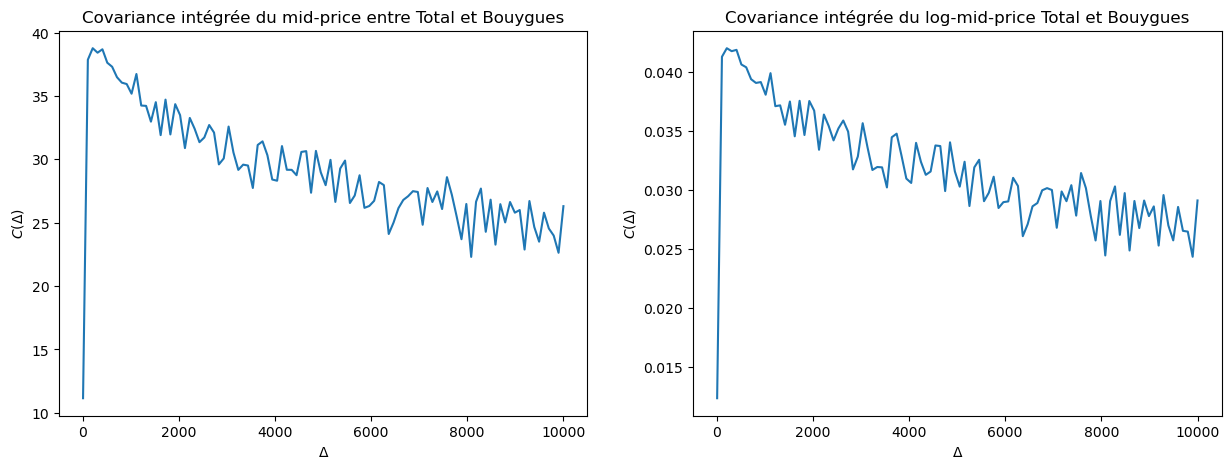

In [15]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].plot(deltas, cov1)
ax[0].set_xlabel("$\Delta$")
ax[0].set_ylabel("$C(\Delta)$")
ax[0].set_title("Covariance intégrée du mid-price entre Total et Bouygues")
ax[1].plot(deltas, cov2)
ax[1].set_xlabel("$\Delta$")
ax[1].set_ylabel("$C(\Delta)$")
ax[1].set_title("Covariance intégrée du log-mid-price Total et Bouygues")
plt.show()

In [16]:
N = 100
deltas = np.linspace(10, 10000, N).astype(int)
corr1 = []
corr2 = []

for i in range(N):
    r1 = df1["MidPrice"].resample(str(deltas[i])+"s").last().diff().dropna()
    v1 = np.sqrt( (r1**2).sum() )
    r2 = df2["MidPrice"].resample(str(deltas[i])+"s").last().diff().dropna()
    v2 = np.sqrt( (r2**2).sum() )
    corr1.append( (r1*r2).sum() / (v1*v2) )

    r1 = df1["LogMidPrice"].resample(str(deltas[i])+"s").last().diff().dropna()
    v1 = np.sqrt( (r1**2).sum() )
    r2 = df2["LogMidPrice"].resample(str(deltas[i])+"s").last().diff().dropna()
    v2 = np.sqrt( (r2**2).sum() )
    corr2.append( (r1*r2).sum() / (v1*v2) )

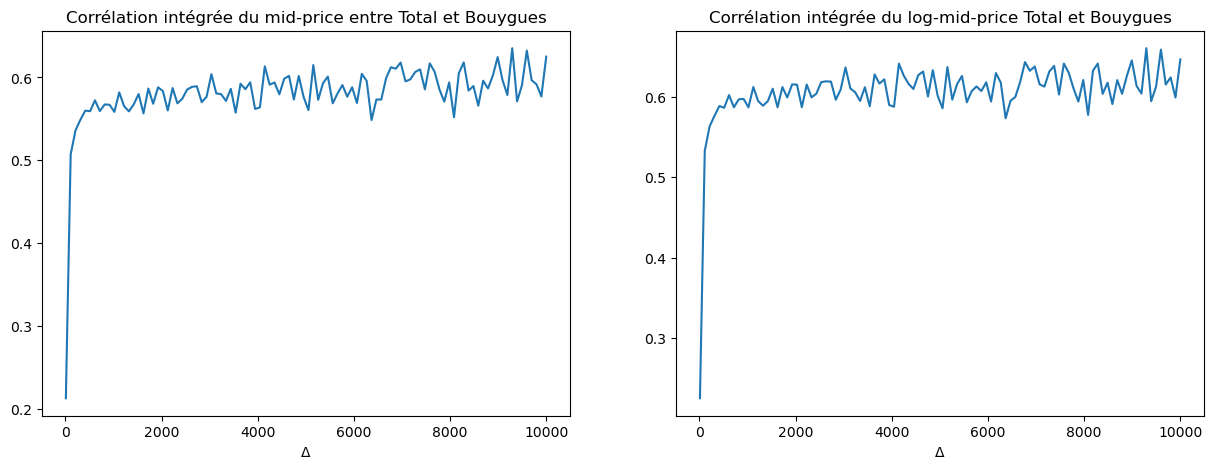

In [17]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].plot(deltas, corr1)
ax[0].set_xlabel("$\Delta$")
ax[0].set_title("Corrélation intégrée du mid-price entre Total et Bouygues")
ax[1].plot(deltas,corr2)
ax[1].set_xlabel("$\Delta$")
ax[1].set_title("Corrélation intégrée du log-mid-price Total et Bouygues")
plt.show()

We can very clearly see here the _Epps effect_.

We can see that the integrated correlation converges for $\Delta$ big enough.

The correlation estimator for high-frequency data is studied in many publications, for example Hayashi & Yoshida or Zhang.

### 4. Hayashi-Yoshida Estimator

Let $I^1_i=(T^1_i,T^1_{i+1}]$, $i\geq1$, and $I^2_j=(T^2_j,T^2_{j+1}]$, $j\geq1$.

The cumulative covariance estimator of Hayashi-Yoshida reads
$$U_n=\sum_{i,j}\Delta P^1(I^1_i)\Delta P^2(I^2_j)\mathbb{1}_{\{I^1_i\cap I^2_j\neq\emptyset\}}.$$

That is, the product of any pair of increments $\Delta P^1(I^1_i)$ and $\Delta P^2(I^2_j)$ will make a contribution to the summation only when the respective observation intervals $I^1_i$ and $I^2_i$ are overlapping.

This estimator does not need any selection of $\Delta$ and is convergent if the arrival times are independent from the price.

Then, they define two associated correlation estimators
- if $\sigma_1$ and $\sigma_2$ are known,
$$R^1_n=\frac1T\frac{\sum_{i,j}\Delta P^1(I^1_i)\Delta P^2(I^2_j)\mathbb{1}_{\{I^1_i\cap I^2_j\neq\emptyset\}}}{\sigma_1\sigma_2},$$
- if $\sigma_1$ and $\sigma_2$ are known/unknown,
$$R^2_n=\frac{\sum_{i,j}\Delta P^1(I^1_i)\Delta P^2(I^2_j)\mathbb{1}_{\{I^1_i\cap I^2_j\neq\emptyset\}}}{\sqrt{\sum_i\Delta P^1(I^1_i)^2}\sqrt{\sum_j\Delta P^2(I^2_j)^2}}.$$
Under the same conditions as for $U_n$, $R^1$ and $R^2$ are consistent for $\rho$ as $n\to\infty$.

**Remark.** This estimator is nevertheless not robust to microstructure effects.

<font color='blue'>**To do.** Compute the daily Hayashi-Yoshida estimator for couples of assets on the same exchange and compare it to classical estimator. Do it for one month you choose and plot the results. Comment. </font>

In [18]:
dates1 = np.unique(df1.index.date)
dates2 = np.unique(df2.index.date)

In [19]:
data1 = df1[df1.index.date == dates1[0]]
data2 = df2[df2.index.date == dates2[0]]

sigma1 = np.sqrt((data1["DiffMidPrice"]**2).sum())
sigma2 = np.sqrt((data2["DiffMidPrice"]**2).sum())

mid_price1 = data1["MidPrice"][ data1["DiffMidPrice"] != 0 ]
mid_price2 = data2["MidPrice"][ data2["DiffMidPrice"] != 0 ]

serie1 = pd.DataFrame(np.array(mid_price1.diff().dropna()), columns=["DiffMidPrice"])
serie1["start"] = mid_price1.index[:-1]
serie1["end"] = mid_price1.index[1:]

serie2 = pd.DataFrame(np.array(mid_price2.diff().dropna()), columns=["DiffMidPrice"])
serie2["start"] = mid_price2.index[:-1]
serie2["end"] = mid_price2.index[1:]


In [20]:
serie1.head()

,DiffMidPrice,start,end
0,0.0275,2011-01-03 09:00:02.431,2011-01-03 09:00:05.000
1,-0.0125,2011-01-03 09:00:05.000,2011-01-03 09:00:08.074
2,0.0050,2011-01-03 09:00:08.074,2011-01-03 09:00:10.864
3,0.0275,2011-01-03 09:00:10.864,2011-01-03 09:00:11.369
4,0.0075,2011-01-03 09:00:11.369,2011-01-03 09:00:12.017


In [21]:
serie2.head()

,DiffMidPrice,start,end
0,0.0150,2011-01-03 09:00:02.379,2011-01-03 09:00:17.107
1,-0.0050,2011-01-03 09:00:17.107,2011-01-03 09:00:17.404
2,-0.0175,2011-01-03 09:00:17.404,2011-01-03 09:00:24.074
3,-0.0300,2011-01-03 09:00:24.074,2011-01-03 09:00:25.398
4,0.0275,2011-01-03 09:00:25.398,2011-01-03 09:00:28.587


In [22]:
cov = 0
for i in range(len(serie1.index)):
    start = serie1["start"].iloc[i]
    end = serie1["end"].iloc[i]
    cov += serie1["DiffMidPrice"].iloc[i] * np.sum( serie2["DiffMidPrice"].loc[ ((serie2["start"]<end) & (serie2["end"]>start)) ])
corr = cov/(sigma1*sigma2)
corr

0.16187044959718636

## III. Link between bid-ask spread and volatility per trade for large tick assets

Dayri and Rosenbaum developed a new approach to exhibit the relationship between bid-ask spread and volatility per trade for large tick assets. The model derives from the one with uncertainty zones. They assume the existence of a {\em latent price} representing the opinion of market participants on the ``true'' price and modeled by a continuous Brownian semi-martingale $(x_t)_{t\geq0}$. Let $\alpha$ be the tick size of the asset. The areas of uncertainty are defined as bands around the middle of the tick size with width $2\eta\alpha$, $0<\eta<1$. The dynamics of the price of the last transaction $p_t$ is obtained as a function of the latent price and areas of uncertainty. The bid-ask spread is assumed to be constant and equal to the tick size $\alpha$. 

The authors define alternating (resp. continuity) of a tick size as a jump in the price of a tick size whose direction is adverse (resp. the same) than the previous jump. The number of alternations and continuities of a tick size are denoted by $N_{\alpha,t}^{(a)}$ and $N_{\alpha,t}^{(c)}$ respectively on the period $[0,t]$. The consistent estimator of $\eta$ on $[0,t]$ is then
$$\widehat{\eta}_{\alpha,t}=\frac{N_{\alpha,t}^{(c)}}{2N_{\alpha,t}^{(a)}}.$$
For volatility, first note that this model allows to find the value of the latent price on the date of $\tau_i$ of the $i^{th}$ price change by the simple relationship
$$x_{\tau_i}=p_{\tau_i}-\mbox{sign}\left(p_{\tau_i}-p_{\tau_{i-1}}\right)\left(\frac12-\eta\right)\alpha.$$
As we can estimate $\eta$, we can then find out $x_{\tau_i}$ from $p_{\tau_{i-1}}$ and $p_{\tau_i}$. For example, the realized variance on estimated values of the efficient price on $[0,t]$
$$\widehat{\sigma^2_{LP,t}}=\sum_{\tau_i\leq t}\left(\widehat{x}_{\tau_i}-\widehat{x}_{\tau_{i-1}}\right)^2,$$
where $\widehat{x}_{\tau_i}=p_{\tau_i}-\mbox{sign}\left(p_{\tau_i}-p_{\tau_{i-1}}\right)\left(\frac12-\widehat{\eta}_{\alpha,t}\right)\alpha$, is an estimator of the integrated variance of the latent price over $[0,t]$ $\int_0^t\sigma_s^2ds$. Now we set $\widehat{\sigma}_{LP}=\sqrt{\widehat{\sigma^2_{[0,t]}}}$ and we define the volatility per trade by $\widehat{\sigma}_{LP}/\sqrt{N}$ where $N:=N_{[0,t]}$ denotes the total number of trades on $[0,t]$. Without making any differences between parameters and their estimates, we get then the following relationship
\begin{equation}\label{EtaLP}
\eta\alpha\approx c\frac{\sigma_{LP}}{\sqrt{N}}.
\end{equation}
Market participants have a certain resolution, or precision at which they infer the efficient price $x_t$. $\eta$ quantifies this resolution: when $\eta$ is close to 1/2, the resolution is close to the tick value. The quantity $2\eta\alpha$ can be seen as an implicit spread: $\eta$ can indeed be viewed as a suitable measure for the tick size.


<font color='blue'>**To do.** 1. Compute $\eta$, $\alpha$ and $\sigma_{LP}$ on a daily basis for each asset. Compare the implicit spread and the real spread. Idem for the volatilities of both latent price and traded price. Comment.</font>

In [23]:
diff_price1 = df1["TradedPrice"].diff()
diff_price2 = df2["TradedPrice"].diff()
alpha1 = np.abs(diff_price1[diff_price1 != 0]).resample("D").min().dropna()
alpha2 = np.abs(diff_price2[diff_price2 != 0]).resample("D").min().dropna()
print("Tick moyen de Total : "+str(alpha1.mean()))
print("Tick moyen de Bouygues : "+str(alpha2.mean()))

Tick moyen de Total : 0.004999999999995496
Tick moyen de Bouygues : 0.004999999999997587


We observe the same average tick size for Total and Bouygues, which makes sense as they are listed on the same exchange.

In [24]:
dates1 = np.unique(df1.index.date)
eta1 = []
for d in range(len(dates1)):
    returns = df1["TradedPrice"][df1.index.date == dates1[d]].diff().dropna()
    returns = np.array(returns[returns != 0])
    Nc = np.sum(returns[1:]*returns[:-1] > 0)
    Na = np.sum(returns[1:]*returns[:-1] < 0)
    eta1.append(Nc/(2*Na))

In [25]:
dates2 = np.unique(df2.index.date)
eta2 = []
for d in range(len(dates2)):
    returns = df2["TradedPrice"][df2.index.date == dates2[d]].diff().dropna()
    returns = np.array(returns[returns != 0])
    Nc = np.sum(returns[1:]*returns[:-1] > 0)
    Na = np.sum(returns[1:]*returns[:-1] < 0)
    eta2.append(Nc/(2*Na))

In [26]:
print("Eta moyen de Total : "+str(np.mean(eta1)))
print("Eta moyen de Bouygues : "+str(np.mean(eta2)))

Eta moyen de Total : 0.5208761519324173
Eta moyen de Bouygues : 0.5347871844427898


We can observe that Total and Bouygues have the same $\eta$, which is coherent with the previous result, since that both companies are french, comparable size and have the same tick size.

In [27]:
vol_lp1 = []
nb_trades1 = []
for d in range(len(dates1)):
    df = df1[df1.index.date == dates1[d]]
    nb_trades1.append(len(df["TradedPrice"]))
    latent_price = df["TradedPrice"][1:] - np.sign(df["TradedPrice"].diff().dropna())*(0.5-eta1[d])
    vol_lp1.append(np.sqrt(np.sum(np.diff(latent_price)**2)))

vol_lp2 = []
nb_trades2 = []
for d in range(len(dates2)):
    df = df2[df2.index.date == dates2[d]]
    nb_trades2.append(len(df["TradedPrice"]))
    latent_price = df["TradedPrice"][1:] - np.sign(df["TradedPrice"].diff().dropna())*(0.5-eta1[d])
    vol_lp2.append(np.sqrt(np.sum(np.diff(latent_price)**2)))
    

<font color='blue'> 2. Implement the linear regression for large tick asset and compare to the results of the previous practical work.</font>

In [28]:
spread1 = eta1 * alpha1 * np.sqrt(nb_trades1)
spread2 = eta2 * alpha2 * np.sqrt(nb_trades2)
S1 = sm.add_constant(spread1)
S2 = sm.add_constant(spread2)

model1 = sm.OLS(vol_lp1, S1).fit()
model2 = sm.OLS(vol_lp2, S2).fit()


Text(0.5, 1.0, 'Bouygues')

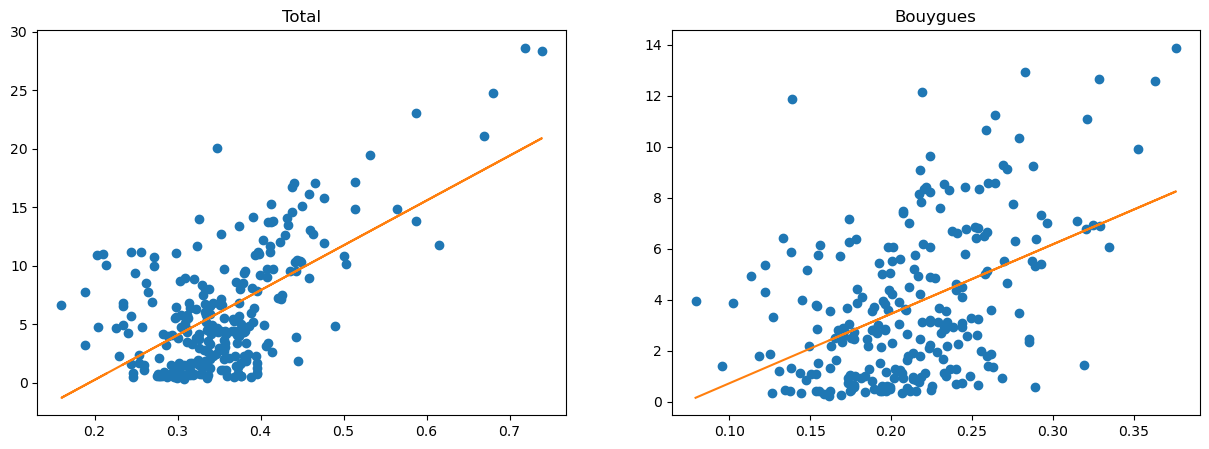

In [29]:
fig, axes = plt.subplots(1,2, figsize = (15,5))
axes[0].plot(S1["TradedPrice"], vol_lp1,'o')
axes[0].plot(S1["TradedPrice"],model1.params.const+model1.params[1]*S1['TradedPrice'])
axes[0].set_title("Total")
axes[1].plot(S2["TradedPrice"], vol_lp2,'o')
axes[1].plot(S2["TradedPrice"],model2.params.const+model2.params[1]*S2['TradedPrice'])
axes[1].set_title("Bouygues")

In [30]:
df1['Spread'] = df1['AskPrice'] - df1['BidPrice']
df2['Spread'] = df2['AskPrice'] - df2['BidPrice']

In [35]:
spread1 = eta1 * alpha1 * np.sqrt(nb_trades1)
spread2 = eta2 * alpha2 * np.sqrt(nb_trades2)
s1 = df1["Spread"].resample('D').mean().dropna()*np.sqrt(nb_trades1)
s2 = df2["Spread"].resample('D').mean().dropna()*np.sqrt(nb_trades2)
S1 = sm.add_constant(pd.concat([spread1,s1], axis=1))
S2 = sm.add_constant(pd.concat([spread2,s2], axis=1))

model1 = sm.OLS(vol_lp1, S1).fit()
model2 = sm.OLS(vol_lp2, S2).fit()

# Régression linéaire de la volatilité du prix latent sur le spread implicite et le spread observé
spread1 = eta1 * alpha1 * np.sqrt(nb_trades1)
spread2 = eta2 * alpha2 * np.sqrt(nb_trades2)
s1 = df1["Spread"].resample('D').mean().dropna()*np.sqrt(nb_trades1)
s2 = df2["Spread"].resample('D').mean().dropna()*np.sqrt(nb_trades2)
S1 = sm.add_constant(pd.concat([spread1,s1], axis=1))
S2 = sm.add_constant(pd.concat([spread2,s2], axis=1))

model1 = sm.OLS(vol_lp1, S1).fit()
model2 = sm.OLS(vol_lp2, S2).fit()
   

Text(0.5, 1.0, 'Bouygues')

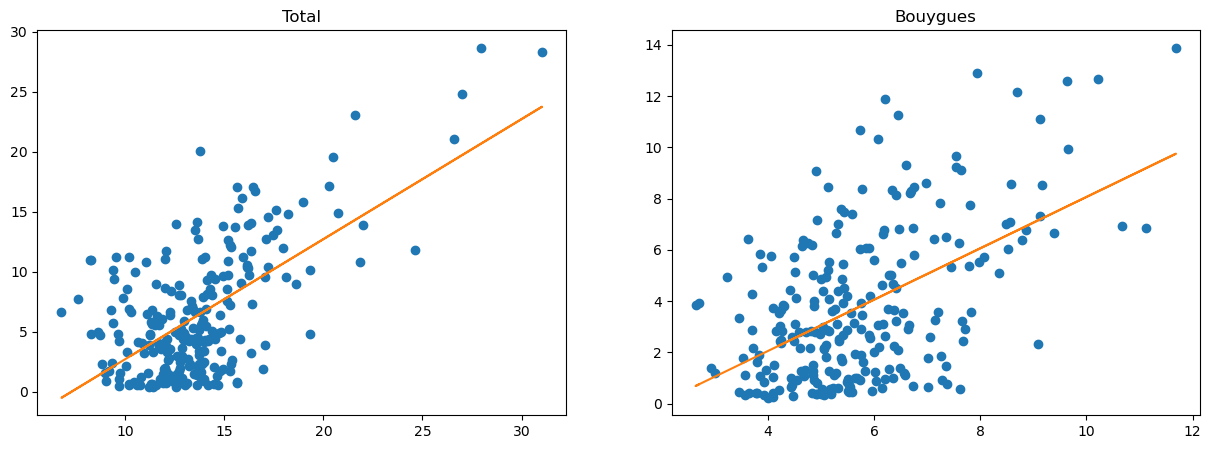

In [34]:
fig, axes = plt.subplots(1,2, figsize = (15,5))
axes[0].plot(model1.params[1]*S1["TradedPrice"]+model1.params[2]*S1["Spread"], vol_lp1,'o')
axes[0].plot(model1.params[1]*S1["TradedPrice"]+model1.params[2]*S1["Spread"], model1.params.const+model1.params[1]*S1["TradedPrice"]+model1.params[2]*S1["Spread"])
axes[0].set_title("Total")

axes[1].plot(model2.params[1]*S2["TradedPrice"]+model2.params[2]*S2["Spread"], vol_lp2,'o')
axes[1].plot(model2.params[1]*S2["TradedPrice"]+model2.params[2]*S2["Spread"], model2.params.const+model2.params[1]*S2["TradedPrice"]+model2.params[2]*S2["Spread"])
axes[1].set_title("Bouygues")